# Importing Library

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Connect to Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Split data train, data valid, data test

In [ ]:
# # folder_name = ['cacar_air', 'cacar_monyet', 'campak', 'normal']

# os.chdir('drive/MyDrive/DATA/skripsi/dataset-rgb-fixed')
# if os.path.isdir('train/cacar_air/') is False:
#   os.mkdir('train')
#   os.mkdir('valid')
#   os.mkdir('test')

# for i in range(len(folder_name)):
#   shutil.move(f'{folder_name[i]}','train')
#   os.mkdir(f'valid/{folder_name[i]}')
#   os.mkdir(f'test/{folder_name[i]}')

#   valid_samples = random.sample(os.listdir(f'train/{folder_name[i]}'), 100)
#   for j in valid_samples:
#     shutil.move(f'train/{folder_name[i]}/{j}', f'valid/{folder_name[i]}')

#   test_samples = random.sample(os.listdir(f'train/{folder_name[i]}'), 50)
#   for k in test_samples:
#     shutil.move(f'train/{folder_name[i]}/{k}', f'test/{folder_name[i]}')

# os.chdir('../..')

In [ ]:
train_path = 'drive/MyDrive/DATA/skripsi/dataset-rgb-fixed-1-splitted/train'
valid_path = 'drive/MyDrive/DATA/skripsi/dataset-rgb-fixed-1-splitted/val'
test_path = 'drive/MyDrive/DATA/skripsi/dataset-rgb-fixed-1-splitted/test'

# Build MobileNetV2 Model with Transfer Learning

In [ ]:
IMG_SHAPE = (128, 128, 3)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [ ]:
base_model.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

In [ ]:
# custom head network
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
# dropout_layer = tf.keras.layers.Dropout(0.2)(global_average_layer)
# prediction_layer = tf.keras.layers.Dense(units=4, activation='softmax')(dropout_layer)
prediction_layer = tf.keras.layers.Dense(units=4, activation='softmax')(global_average_layer)

In [ ]:
# combine model
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [ ]:
# mobile = tf.keras.applications.mobilenet_v2.MobileNetV2()
# # mobile = tf.keras.applications.mobilenet.MobileNet()
# mobile.summary()

In [ ]:
# x = mobile.layers[-5].output

In [ ]:
# x = tf.keras.layers.Reshape(target_shape=(1024,))(x)
# output = Dense(units=10, activation='softmax')(x)

In [ ]:
# model = Model(inputs=mobile.input, outputs=output)

In [ ]:
# for layer in model.layers[:-22]:
#   layer.trainable = False

In [ ]:
# model.summary()

# Tahap Pelatihan

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(128,128), batch_size=5)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(128,128), batch_size=5)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(128,128), batch_size=5, shuffle=False)

Found 1808 images belonging to 4 classes.
Found 226 images belonging to 4 classes.
Found 226 images belonging to 4 classes.


# Train The Model

Softmax + RMSprop

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.045), loss="categorical_crossentropy", metrics=["accuracy"]) #v2

history = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=5,
            verbose=2
)

Epoch 1/5
362/362 - 396s - loss: 3.8149 - accuracy: 0.8263 - val_loss: 3.3459 - val_accuracy: 0.8496 - 396s/epoch - 1s/step
Epoch 2/5
362/362 - 29s - loss: 1.3003 - accuracy: 0.9425 - val_loss: 1.6079 - val_accuracy: 0.9204 - 29s/epoch - 80ms/step
Epoch 3/5
362/362 - 31s - loss: 1.1161 - accuracy: 0.9452 - val_loss: 1.1177 - val_accuracy: 0.9513 - 31s/epoch - 86ms/step
Epoch 4/5
362/362 - 31s - loss: 0.5823 - accuracy: 0.9729 - val_loss: 1.5460 - val_accuracy: 0.9381 - 31s/epoch - 86ms/step
Epoch 5/5
362/362 - 29s - loss: 0.5228 - accuracy: 0.9729 - val_loss: 0.9367 - val_accuracy: 0.9513 - 29s/epoch - 80ms/step


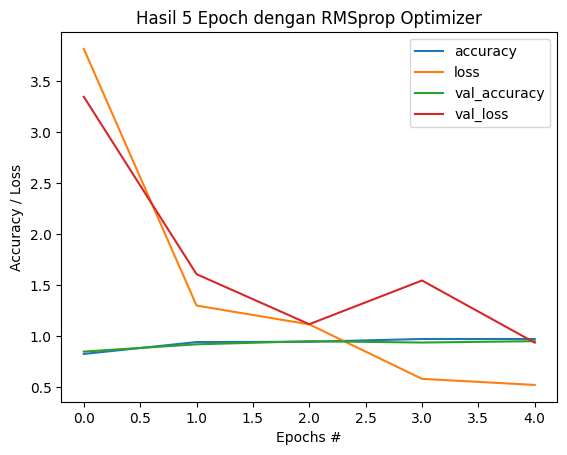

In [ ]:
# Plotting
hist = history.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.title("Hasil 5 Epoch dengan RMSprop Optimizer")
plt.show()

In [ ]:
test_labels = test_batches.classes

predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=2)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

46/46 - 55s - 55s/epoch - 1s/step


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[50  1  0  1]
 [ 1 58  0  1]
 [ 1  2 51  0]
 [ 0  0  0 60]]


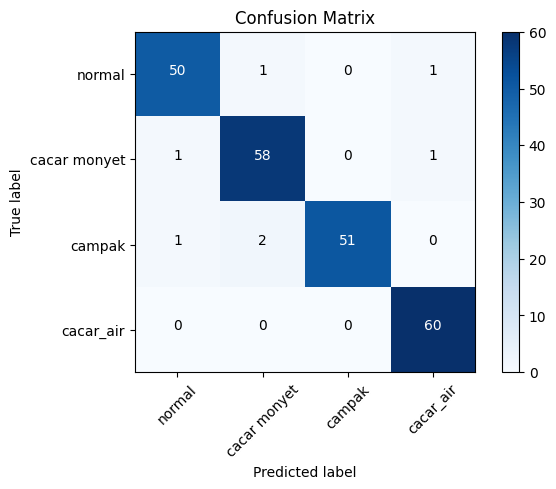

In [ ]:
cm_plot_labels = ['normal','cacar monyet','campak','cacar_air']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
# classification report

print(classification_report(test_labels, predictions.argmax(axis=1), target_names=cm_plot_labels))

              precision    recall  f1-score   support

      normal       0.96      0.96      0.96        52
cacar monyet       0.95      0.97      0.96        60
      campak       1.00      0.94      0.97        54
   cacar_air       0.97      1.00      0.98        60

    accuracy                           0.97       226
   macro avg       0.97      0.97      0.97       226
weighted avg       0.97      0.97      0.97       226



EPOCH 10

In [ ]:
#train the model

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.045), loss="categorical_crossentropy", metrics=["accuracy"]) #v2
# model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) #yg v1

#yg rgb 2000images
history = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=10,
            verbose=2
)

Epoch 1/10
332/332 - 25s - loss: 0.3216 - accuracy: 0.9831 - val_loss: 1.3474 - val_accuracy: 0.9375 - 25s/epoch - 76ms/step
Epoch 2/10
332/332 - 23s - loss: 0.2630 - accuracy: 0.9861 - val_loss: 1.7103 - val_accuracy: 0.9450 - 23s/epoch - 69ms/step
Epoch 3/10
332/332 - 23s - loss: 0.2576 - accuracy: 0.9849 - val_loss: 0.5303 - val_accuracy: 0.9750 - 23s/epoch - 68ms/step
Epoch 4/10
332/332 - 23s - loss: 0.2502 - accuracy: 0.9849 - val_loss: 0.5612 - val_accuracy: 0.9700 - 23s/epoch - 68ms/step
Epoch 5/10
332/332 - 23s - loss: 0.1742 - accuracy: 0.9904 - val_loss: 0.4463 - val_accuracy: 0.9775 - 23s/epoch - 71ms/step
Epoch 6/10
332/332 - 22s - loss: 0.0932 - accuracy: 0.9928 - val_loss: 0.5573 - val_accuracy: 0.9750 - 22s/epoch - 68ms/step
Epoch 7/10
332/332 - 22s - loss: 0.1784 - accuracy: 0.9910 - val_loss: 0.9996 - val_accuracy: 0.9675 - 22s/epoch - 68ms/step
Epoch 8/10
332/332 - 24s - loss: 0.2031 - accuracy: 0.9873 - val_loss: 0.9422 - val_accuracy: 0.9675 - 24s/epoch - 72ms/step


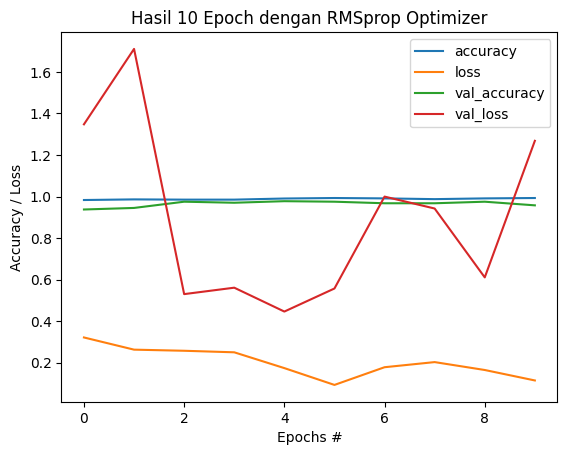

In [ ]:
# Plotting
hist = history.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.title("Hasil 10 Epoch dengan RMSprop Optimizer")
plt.show()

In [ ]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=2)

40/40 - 3s - 3s/epoch - 69ms/step


In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

Confusion matrix, without normalization
[[47  1  2  0]
 [ 0 50  0  0]
 [ 0  0 50  0]
 [ 1  1  3 45]]


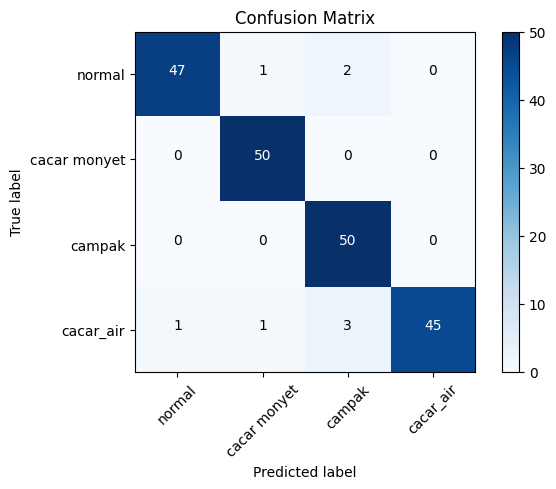

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
# classification report

print(classification_report(test_labels, predictions.argmax(axis=1), target_names=cm_plot_labels))

              precision    recall  f1-score   support

      normal       0.98      0.94      0.96        50
cacar monyet       0.96      1.00      0.98        50
      campak       0.91      1.00      0.95        50
   cacar_air       1.00      0.90      0.95        50

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



EPOCH 15

In [ ]:
#train the model

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.045), loss="categorical_crossentropy", metrics=["accuracy"]) #v2

history2 = model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=15,
            verbose=2
)

Epoch 1/15
332/332 - 27s - loss: 0.0992 - accuracy: 0.9934 - val_loss: 0.4886 - val_accuracy: 0.9775 - 27s/epoch - 82ms/step
Epoch 2/15
332/332 - 23s - loss: 0.1398 - accuracy: 0.9934 - val_loss: 0.7062 - val_accuracy: 0.9725 - 23s/epoch - 70ms/step
Epoch 3/15
332/332 - 23s - loss: 0.0991 - accuracy: 0.9970 - val_loss: 0.8253 - val_accuracy: 0.9700 - 23s/epoch - 69ms/step
Epoch 4/15
332/332 - 23s - loss: 0.0086 - accuracy: 0.9988 - val_loss: 0.7844 - val_accuracy: 0.9750 - 23s/epoch - 70ms/step
Epoch 5/15
332/332 - 22s - loss: 0.0123 - accuracy: 0.9994 - val_loss: 0.7132 - val_accuracy: 0.9625 - 22s/epoch - 67ms/step
Epoch 6/15
332/332 - 23s - loss: 0.0500 - accuracy: 0.9976 - val_loss: 0.7706 - val_accuracy: 0.9750 - 23s/epoch - 70ms/step
Epoch 7/15
332/332 - 23s - loss: 0.0321 - accuracy: 0.9982 - val_loss: 0.8894 - val_accuracy: 0.9725 - 23s/epoch - 68ms/step
Epoch 8/15
332/332 - 23s - loss: 0.0178 - accuracy: 0.9994 - val_loss: 0.9307 - val_accuracy: 0.9700 - 23s/epoch - 69ms/step


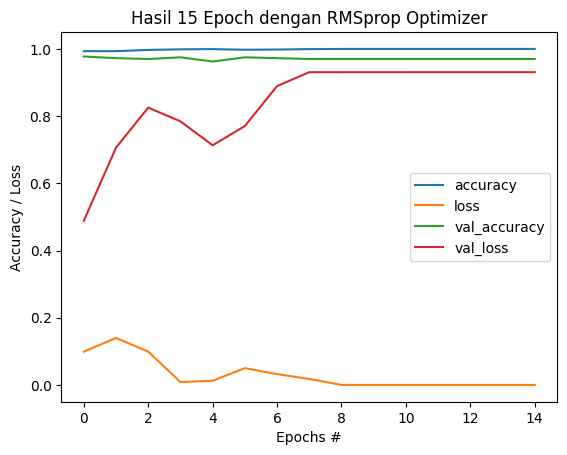

In [ ]:
# Plotting
hist = history2.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.title("Hasil 15 Epoch dengan RMSprop Optimizer")
plt.show()

In [ ]:
# model.save("drive/MyDrive/DATA/skripsi/monkeypox2-rgb2260-mobilenetv2.h5")

In [ ]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=2)

40/40 - 3s - 3s/epoch - 67ms/step


In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

Confusion matrix, without normalization
[[49  0  1  0]
 [ 0 50  0  0]
 [ 1  0 49  0]
 [ 0  0  0 50]]


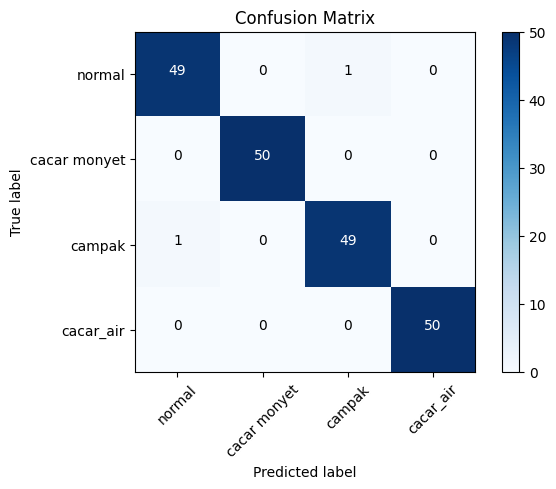

In [ ]:
cm_plot_labels = ['normal','cacar monyet','campak','cacar_air']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
# classification report

print(classification_report(test_labels, predictions.argmax(axis=1), target_names=cm_plot_labels))

              precision    recall  f1-score   support

      normal       0.98      0.98      0.98        50
cacar monyet       1.00      1.00      1.00        50
      campak       0.98      0.98      0.98        50
   cacar_air       1.00      1.00      1.00        50

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

